# Full Pipeline Notebook

This notebook bundles configuration, dataset utilities, model definitions, training loop, and evaluation into a single self‑contained workflow.

## 1. Configurations (Imports & Hyperparameters)

In [1]:
import os
import sys
import random
import json
import time
import numpy as np
import pandas as pd                             
import torch
import torch.nn as nn
from torch.utils.data import DataLoader 
from torch.amp import autocast
from torch.optim import AdamW, lr_scheduler
from torchvision import transforms
import timm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from data_utils import DataPartition, MixupCutmixWrapper, RandomHorizontalRoll
# import warnings # Suppress warnings that currently do not affect execution
# warnings.filterwarnings("ignore", message="torch.meshgrid: in an upcoming release")
# warnings.filterwarnings("ignore", message="Cannot set number of intraop threads after parallel work has started or after set_num_threads call")

# Hyperparameters
USE_GPU = True
MODEL_NAME = "swinv2_base_window12to24_192to384"
IMG_WIDTH = 384
N_EPOCHS = 100          
BATCH_SIZE = 8
ACCUMULATION_STEPS = 2
PATIENCE = 15
DROPOUT_RATE = 0.5
LEARNING_RATE = 3e-5
WEIGHT_DECAY  = 0.01 
MIN_LR = 1e-7

RANDOM_SEED = 42

# Reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Device setup
if USE_GPU and torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    optimal_num_workers = min(8, os.cpu_count() // 2)
    pin_memory = True
    amp_dtype = torch.bfloat16
else:
    device = torch.device("cpu")
    optimal_num_workers = 0 
    pin_memory = False
    amp_dtype = torch.float32
print(f"Using device: {device}")


c:\Users\geography\.conda\envs\360deg_env\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\geography\.conda\envs\360deg_env\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\geography\.conda\envs\360deg_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## 2. Dataset Utilities

In [2]:
NDJSON_PATH = 'labels.ndjson'
IMG_DIR = "ALL_SPLIT_IMAGES"
label_columns = [
    "Open Water",
    "Floating Vegetation",
    "Reedlands & Permanent Swamps",
    "Tall Seasonal Sedge Wetlands",
    "Short Seasonal Grass Floodplains",
    "Riparian Forest",
    "Woodlands",
    "Bare Ground / Dry Grass",
    "Shrubland", 
    "[Lvl 2] Water Lily",
    "[Lvl 2] Rafts",
    "[Lvl 2] Salvinia / Other Fern",
    "[Lvl 2] Papyrus",
    "[Lvl 2] Phragmites / Miscanthus"
]

In [3]:
# MUST move DataPartition into a separate file (data_utils.py)
# in order to run the notebook version with num_workers > 0 for GPU training

# ...

# mean and standard deviation of the ImageNet training set SwinV2 pretrained on
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    RandomHorizontalRoll(p=0.5),
    transforms.RandomApply([transforms.RandomAffine(
                            degrees=5,
                            translate=(0.05, 0.05),
                            scale=(0.95, 1.05),
                            shear=(-5, 5))], p=0.5),
    transforms.RandomResizedCrop(IMG_WIDTH, scale=(0.8, 1.0), ratio=(0.8, 1.25), antialias=True), # random crop & scale
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.1),  # vegetation mirrored vertically is still plausible
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.25, scale=(0.02,0.1), ratio=(0.3,3.3), value='random')
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

## 3. Model 

In [ ]:
class customModel(nn.Module):
    def __init__(self, model_name, num_classes, pretrained=True):
        super().__init__()
        # SwinV2 backbone without head/pooling
        self.model = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0, # out_features, strip of model head/classifier
            global_pool="" # no pooling
        )
        in_features = self.model.num_features
        # pooling + dropout + classifier head
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(DROPOUT_RATE)
        self.fully_connect = nn.Linear(in_features, num_classes) # head/classifier

    def forward(self, imgs):
        # get feature map
        fmap = self.model.forward_features(imgs)  # could be [B, H, W, C] or [B, C, H, W]
        if fmap.dim() == 4 and fmap.shape[-1] == self.model.num_features:
            fmap = fmap.permute(0, 3, 1, 2) # Permute to [B, C, H', W']
        # pool + head
        pooled = self.global_avg_pool(fmap).view(fmap.size(0), -1)
        features = self.dropout(pooled)
        output = self.fully_connect(features) # Pass through a linear fc layer to get one score per class for each example in the batch: [B, num_classes]
        return output

## 4. Training Monitor & Trainer

In [5]:
class TrainingMonitor:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.val_mAPs = []
        self.start=time.time()
    def report_epoch(self, train_loss, val_loss, val_map):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.val_mAPs.append(val_map)
    def finish(self):
        total_time = time.time()-self.start
        mins = int(total_time // 60)
        secs = int(total_time % 60)
        print(f"Total Training Time: {mins} min {secs} sec")
        return total_time

class Trainer:
    def __init__(self, model, optimizer, scheduler, criterion, train_loader, val_loader, device, monitor, patience, amp_dtype, accumulation_steps):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.monitor = monitor
        self.patience = patience
        self.amp_dtype = amp_dtype
        self.accumulation_steps = accumulation_steps
        self.best_val_loss = float('inf')
        self.epochs_no_improve = 0
        self.best_state = None

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        total_samples = 0
        self.optimizer.zero_grad()
        for batch_idx, (images, labels) in enumerate(self.train_loader):
            images = images.to(self.device)
            labels = labels.to(self.device)
            with autocast(device_type=self.device.type, dtype=self.amp_dtype): # GPU: forward + loss w/ BF16 Automatic Mixed Precision. Default: FP32 precision
                logits = self.model(images)
                loss = self.criterion(logits, labels)
                loss = loss / self.accumulation_steps
            loss.backward()# backward pass
            if (batch_idx + 1) % self.accumulation_steps == 0:
                self.optimizer.step()
                self.optimizer.zero_grad()
            batch_size = images.size(0)  
            running_loss += loss.item() * batch_size * self.accumulation_steps
            total_samples += batch_size
        if (batch_idx + 1) % self.accumulation_steps != 0: # flush gradients if the last batch didn’t trigger a step
            self.optimizer.step()
            self.optimizer.zero_grad()
        epoch_loss = running_loss / total_samples
        return epoch_loss
    
    def validate_epoch(self):
        self.model.eval()
        running_loss = 0.0
        total_samples = 0
        all_probs = []
        all_labels = []
        with torch.no_grad():
            for imgs, labels in self.val_loader:
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)
                logits = self.model(imgs)
                loss = self.criterion(logits, labels)
                batch_size = imgs.size(0)
                running_loss += loss.item() * batch_size
                total_samples += batch_size
                probabilities = torch.sigmoid(logits)
                all_probs.append(probabilities.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        val_loss = running_loss / total_samples
        all_probs = np.vstack(all_probs)
        all_labels = np.vstack(all_labels)
        per_label_AP = [average_precision_score(all_labels[:, i], all_probs[:, i]) for i in range(all_labels.shape[1])]
        val_mAP = float(np.mean(per_label_AP))
        return val_loss, per_label_AP, val_mAP

    def train(self, num_epochs):
        for epoch in range(1, num_epochs + 1):
            start = time.time()
            train_loss = self.train_epoch()
            val_loss, val_per_label_AP, val_mAP = self.validate_epoch()
            total_time = time.time() - start
            mins = int(total_time // 60)
            secs = int(total_time % 60)
            # Scheduler steps 
            self.scheduler.step()
            # Print epoch summary
            print(f"\nEpoch {epoch}: Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | Val mAP={val_mAP:.4f} ({mins} min {secs} sec)")
            # Early stopping & per‐class AP logging
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.epochs_no_improve = 0
                self.best_state = self.model.state_dict()
                torch.save(self.best_state, "best_model.pt")
                print(f"New best_model.pt saved at epoch {epoch} with val loss: {val_loss:.4f}")
                # Print a little table of per‐class AP
                print("   Validation per-class AP:")
                label_names = self.val_loader.dataset.label_columns
                for name, AP in zip(label_names, val_per_label_AP):
                    print(f"     {name:<40} {AP:.4f}")
                print(f"   Validation mean AP: {val_mAP:.4f}")
            else:
                self.epochs_no_improve += 1
                if self.epochs_no_improve >= self.patience:
                    print("Early stopping triggered.")
                    break
            # Record in monitor
            self.monitor.report_epoch(train_loss, val_loss, val_mAP)
        if self.best_state is not None:
            self.model.load_state_dict(self.best_state) # Load best weights
        self.monitor.finish() 
    
class TeeOutput:
    def __init__(self, filename, mode='w'):
        self.terminal = sys.stdout
        self.log = open(filename, mode)

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)

    def close(self):
        self.log.close()

def log_hyperparameters():
    print("\n========== HYPERPARAMETERS ==========")
    # print(f"DEBUG_MODE:        {DEBUG_MODE}")
    print(f"USE_GPU:           {USE_GPU}")
    print(f"MODEL_NAME:        {MODEL_NAME}")
    print(f"IMG_WIDTH:         {IMG_WIDTH}")
    print(f"N_EPOCHS:          {N_EPOCHS}")
    print(f"BATCH_SIZE:        {BATCH_SIZE}")
    print(f"ACCUMULATION_STEPS:{ACCUMULATION_STEPS}")
    print(f"PATIENCE:          {PATIENCE}")
    print(f"DROPOUT_RATE:      {DROPOUT_RATE}")  
    print(f"LEARNING_RATE:     {LEARNING_RATE}")
    print(f"WEIGHT_DECAY:      {WEIGHT_DECAY}")
    print(f"MIN_LR:            {MIN_LR}")
    # print(f"TRAIN_RATIO:       {TRAIN_RATIO}")
    # print(f"VAL_RATIO:         {VAL_RATIO}")
    # print(f"TEST_RATIO:        {TEST_RATIO}")
    print(f"RANDOM_SEED:       {RANDOM_SEED}")
    print("=====================================\n")

## 5. Prediction/Evaluation Thresholding

In [6]:
def find_optimal_thresholds(model, val_loader, device, num_classes):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            logits = model(images)
            all_probs.append(torch.sigmoid(logits).cpu().numpy())
            all_labels.append(labels.numpy())
    all_probs  = np.vstack(all_probs)
    all_labels = np.vstack(all_labels)

    thresholds = np.zeros(num_classes, dtype=float)
    for k in range(num_classes):
        y_true  = all_labels[:, k]
        y_score = all_probs[:, k]
        # get the precision‐recall curve
        prec, rec, th = precision_recall_curve(y_true, y_score)
        # compute F1 at each point
        f1 = 2 * prec * rec / (prec + rec + 1e-8)
        # we drop the last precision/recall entry if it has no corresponding threshold
        f1 = f1[:-1]
        if len(th) == 0:
            # fallback to 0.5 if this class never appears
            thresholds[k] = 0.5
        else:
            best = np.nanargmax(f1)
            thresholds[k] = th[best]
    return thresholds

## 6. Main Training & Evaluation

In [7]:
# Load partitions from .csv
df_train = pd.read_csv("train_partition.csv")
df_val   = pd.read_csv("val_partition.csv")
df_test  = pd.read_csv("test_partition.csv")
print("Partitions loaded from .csv files.")
# DataLoaders
train_dataset = DataPartition(df_train, label_columns, transform=train_transforms)
train_dataset = MixupCutmixWrapper(train_dataset, mixup_alpha=0.4, cutmix_alpha=1.0, prob_mixup=0.3, prob_cutmix=0.3)
val_dataset   = DataPartition(df_val, label_columns, transform=val_transforms)
test_dataset  = DataPartition(df_test, label_columns, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=optimal_num_workers, pin_memory=pin_memory)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=optimal_num_workers, pin_memory=pin_memory)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=optimal_num_workers, pin_memory=pin_memory)
print(f"Train samples:      {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples:       {len(test_dataset)}")
print(f"Using num_workers: {optimal_num_workers}") 


Partitions loaded from .csv files.
Train samples:      1093
Validation samples: 232
Test samples:       233
Using num_workers: 8


In [8]:
# Model, optimizer, scheduler
model = customModel(model_name=MODEL_NAME, num_classes=len(label_columns),pretrained=True).to(device)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, amsgrad=False)

warmup_steps = 5  # first 5 epochs
warmup = lr_scheduler.LinearLR(optimizer, start_factor=1e-3, total_iters=warmup_steps)
cosine = lr_scheduler.CosineAnnealingLR(optimizer, T_max=(N_EPOCHS - warmup_steps), eta_min=MIN_LR)
scheduler = lr_scheduler.ChainedScheduler([warmup, cosine])

# Train 
monitor = TrainingMonitor()
trainer = Trainer(model=model, 
                    optimizer=optimizer,
                    scheduler=scheduler, 
                    criterion=loss_fn,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    device=device, 
                    monitor=monitor,
                    patience=PATIENCE, 
                    amp_dtype=amp_dtype,
                    accumulation_steps=ACCUMULATION_STEPS
    )
sys.stdout = TeeOutput("training_log.txt")
log_hyperparameters()
trainer.train(N_EPOCHS)

# Pick Thresholds for Predictions 
thresholds = find_optimal_thresholds(model, val_loader, device, num_classes=len(label_columns)) # on Validation
print("\nOptimal per-class thresholds:", thresholds)

# Test set evaluation
print("\nTest Set performance:")
model.eval()
all_probs = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images)
        probabilities = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probabilities)
        all_labels.append(labels.numpy())
all_probs  = np.vstack(all_probs)
all_labels = np.vstack(all_labels)
binary_predictions = (all_probs >= thresholds).astype(int)
# Classification Report on Test Set
per_class_AP = [average_precision_score(all_labels[:, i], all_probs[:, i]) for i in range(all_labels.shape[1])]
mean_AP = float(np.mean(per_class_AP))
precisions, recalls, f1s, supports = precision_recall_fscore_support(all_labels, binary_predictions, zero_division=0)
max_label_len = max(len(lbl) for lbl in label_columns)
for idx, label in enumerate(label_columns):
    precision = precisions[idx]
    recall = recalls[idx]
    f1 = f1s[idx]
    num_occurrences = supports[idx]
    print(f"{label:<{max_label_len}} AP={per_class_AP[idx]:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, num_occurences={num_occurrences}")
print(f"Test Set mean AP: {mean_AP:.4f}")
sys.stdout.log.close()
sys.stdout = sys.stdout.terminal


========== HYPERPARAMETERS ==========
USE_GPU:           True
MODEL_NAME:        swinv2_base_window12to24_192to384
IMG_WIDTH:         384
N_EPOCHS:          100
BATCH_SIZE:        8
ACCUMULATION_STEPS:2
PATIENCE:          15
DROPOUT_RATE:      0.5
LEARNING_RATE:     3e-05
WEIGHT_DECAY:      0.01
MIN_LR:            1e-07
RANDOM_SEED:       42


Epoch 1: Train Loss=0.7672 | Val Loss=0.7413 | Val mAP=0.1781 (1 min 52 sec)
New best_model.pt saved at epoch 1 with val loss: 0.7413
   Validation per-class AP:
     Open Water                               0.3292
     Floating Vegetation                      0.0701
     Reedlands & Permanent Swamps             0.4646
     Tall Seasonal Sedge Wetlands             0.1163
     Short Seasonal Grass Floodplains         0.2401
     Riparian Forest                          0.0199
     Woodlands                                0.0190
     Bare Ground / Dry Grass                  0.2825
     Shrubland                                0.0321
     [Lvl 2] W

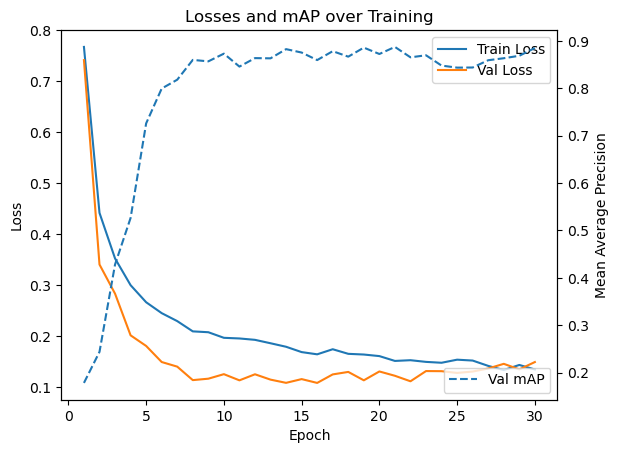

In [9]:
epochs = list(range(1, len(monitor.train_losses)+1))

fig, ax1 = plt.subplots()
ax1.plot(epochs, monitor.train_losses, label="Train Loss")
ax1.plot(epochs, monitor.val_losses,   label="Val Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")

ax2 = ax1.twinx()
ax2.plot(epochs, monitor.val_mAPs,       label="Val mAP", linestyle="--")
ax2.set_ylabel("Mean Average Precision")
ax2.legend(loc="lower right")

plt.title("Losses and mAP over Training")
plt.show()


## 8. Save Config for Classifier

In [10]:
# Save in Classifier
# Build and write the JSON metadata config
config = {
    "model_name": MODEL_NAME,
    "img_width": IMG_WIDTH,
    "mean": mean,         
    "std": std,         
    "label_columns": label_columns, # list of strings
    "thresholds": thresholds.tolist()  # Gather thresholds into a JSON‑safe list
}
with open("best_classifier.json", "w") as outfile:
    json.dump(config, outfile, indent=2)
print(f"Classifier Metadata saved as best_classifier.json")

Classifier Metadata saved as best_classifier.json
